<a href="https://www.kaggle.com/code/seanandrie/ps-s3-e26-weightedensemble-baseline?scriptVersionId=167059210" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier, VotingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import PowerTransformer, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.compose import make_column_transformer
from sklearn.metrics import roc_auc_score, log_loss

sns.set(style = 'whitegrid', palette = 'Set2')

# 2. Fetch Datasets

In [2]:
path = '/kaggle/input/playground-series-s3e26/'
cirrhosis_sp_path = '/kaggle/input/cirrhosis-patient-survival-prediction/'

orig_data = pd.read_csv(cirrhosis_sp_path + 'cirrhosis.csv').drop('ID', axis = 1)

# Reposition 'Status' column to right-most side
orig_data = orig_data[[col for col in orig_data.columns if col not in ['Status']] + ['Status']]

train_data = pd.read_csv(path + 'train.csv').drop('id', axis = 1)

# Ensure that the order of columns are the same as training data
orig_data = orig_data[train_data.columns]

test_data = pd.read_csv(path + 'test.csv').drop('id', axis = 1)
sample_sub = pd.read_csv(path + 'sample_submission.csv')

# 3. Preliminary Data Analysis

## Attribute Information
1) **`ID`**: unique identifier

2) **`N_Days`**: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986

3) **`Status`**: status of the patient `C` (censored), `CL` (censored due to liver tx), or `D` (death)

4) **`Drug`**: type of drug D-penicillamine or placebo

5) **`Age`**: age in [days]

6) **`Sex`**: `M` (male) or `F` (female)

7) **`Ascites`**: presence of ascites `N` (No) or `Y` (Yes)

8) **`Hepatomegaly`**: presence of hepatomegaly `N` (No) or `Y` (Yes)

9) **`Spiders`**: presence of spiders `N` (No) or `Y` (Yes)

10) **`Edema`**: presence of edema `N` (no edema and no diuretic therapy for edema), `S` (edema present without diuretics, or edema resolved by diuretics), or `Y` (edema despite diuretic therapy)

11) **`Bilirubin`**: serum bilirubin in [mg/dl]

12) **`Cholesterol`**: serum cholesterol in [mg/dl]

13) **`Albumin`**: albumin in [gm/dl]

14) **`Copper`**: urine copper in [ug/day]

15) **`Alk_Phos`**: alkaline phosphatase in [U/liter]

16) **`SGOT`**: SGOT in [U/ml]

17) **`Triglycerides`**: triglicerides in [mg/dl]

18) **`Platelets`**: platelets per cubic [ml/1000]

19) **`Prothrombin`**: prothrombin time in seconds [s]

20) **`Stage`**: histologic stage of disease (`1`, `2`, `3`, or`4`)

In [3]:
train_data.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [4]:
test_data.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0


In [5]:
orig_data.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,400,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0,D
1,4500,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0,C
2,1012,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0,D
3,1925,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0,D
4,1504,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0,CL


In [6]:
# Check for null and duplicated values

def null_and_dupes(data, name = None):
    print(f'[{name}] No. of Duplicated rows: {data.duplicated().sum()}, No. of Null values: {data.isnull().sum().sum()}')

null_and_dupes(train_data, 'Train Data')
null_and_dupes(test_data, 'Test Data')
null_and_dupes(orig_data, 'Original Data')

[Train Data] No. of Duplicated rows: 0, No. of Null values: 0
[Test Data] No. of Duplicated rows: 0, No. of Null values: 0
[Original Data] No. of Duplicated rows: 0, No. of Null values: 1033


In [7]:
# Drop null values
orig_data.dropna(inplace = True)

In [8]:
null_and_dupes(orig_data, 'Original Data')

[Original Data] No. of Duplicated rows: 0, No. of Null values: 0


## Categorical Distributions

In [9]:
def count_comparison(data_1, data_2, title = None, figsize = (10, 20)):
    cat_1 = data_1.select_dtypes(include = 'object')
    cat_2 = data_2.select_dtypes(include = 'object')
    
    nrows = len(cat_1.columns)
    ncols = 2
    
    cat_dict = {0: cat_1, 1: cat_2}
    
    fig, ax = plt.subplots(nrows, ncols, figsize = figsize)
    for i in range(len(cat_1.columns)):
        for j in range(2):
            sns.countplot(data = cat_dict[j], x = cat_dict[j].columns[i], ax = ax[i][j])
            ax[i][j].set_xlabel(cat_dict[j].columns[i])
    
    fig.suptitle(title)
    fig.tight_layout(rect = [0, 0.03, 1, 0.98])
    plt.show()

### Train Data vs Original Data Distributions

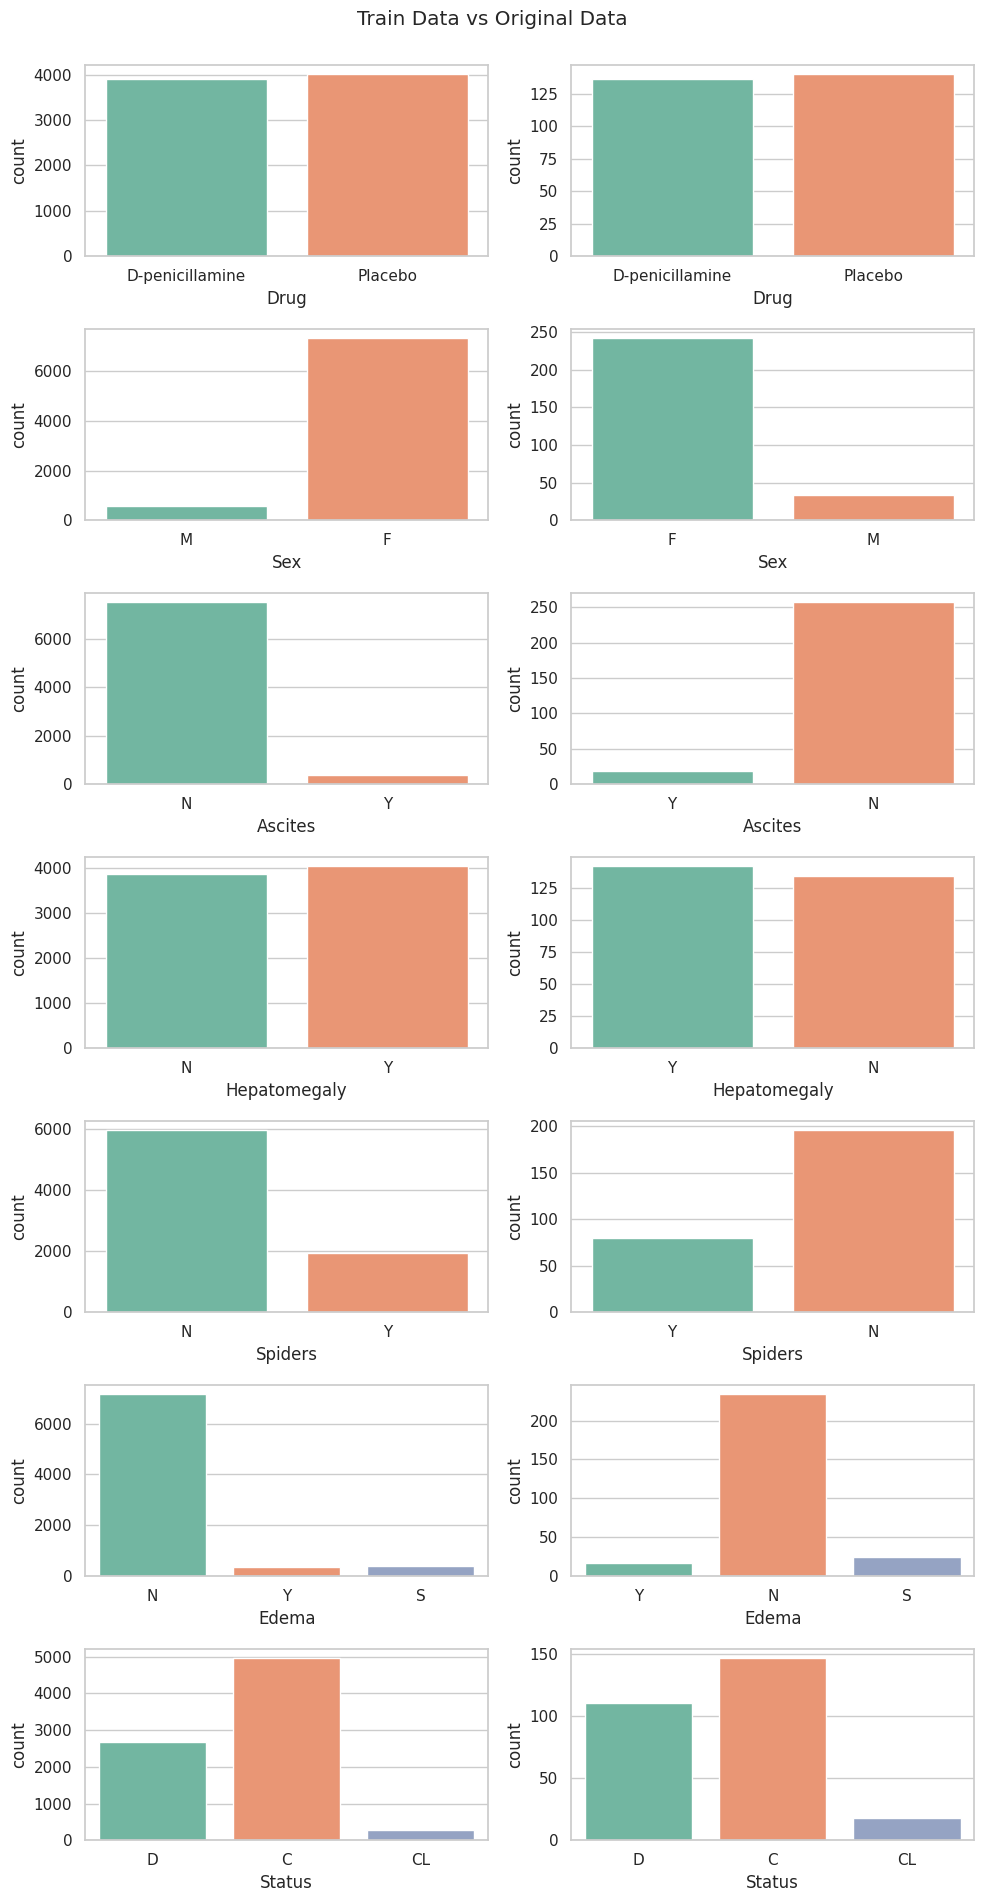

In [10]:
count_comparison(train_data, orig_data, title = 'Train Data vs Original Data')

### Train Data vs Test Data Distributions

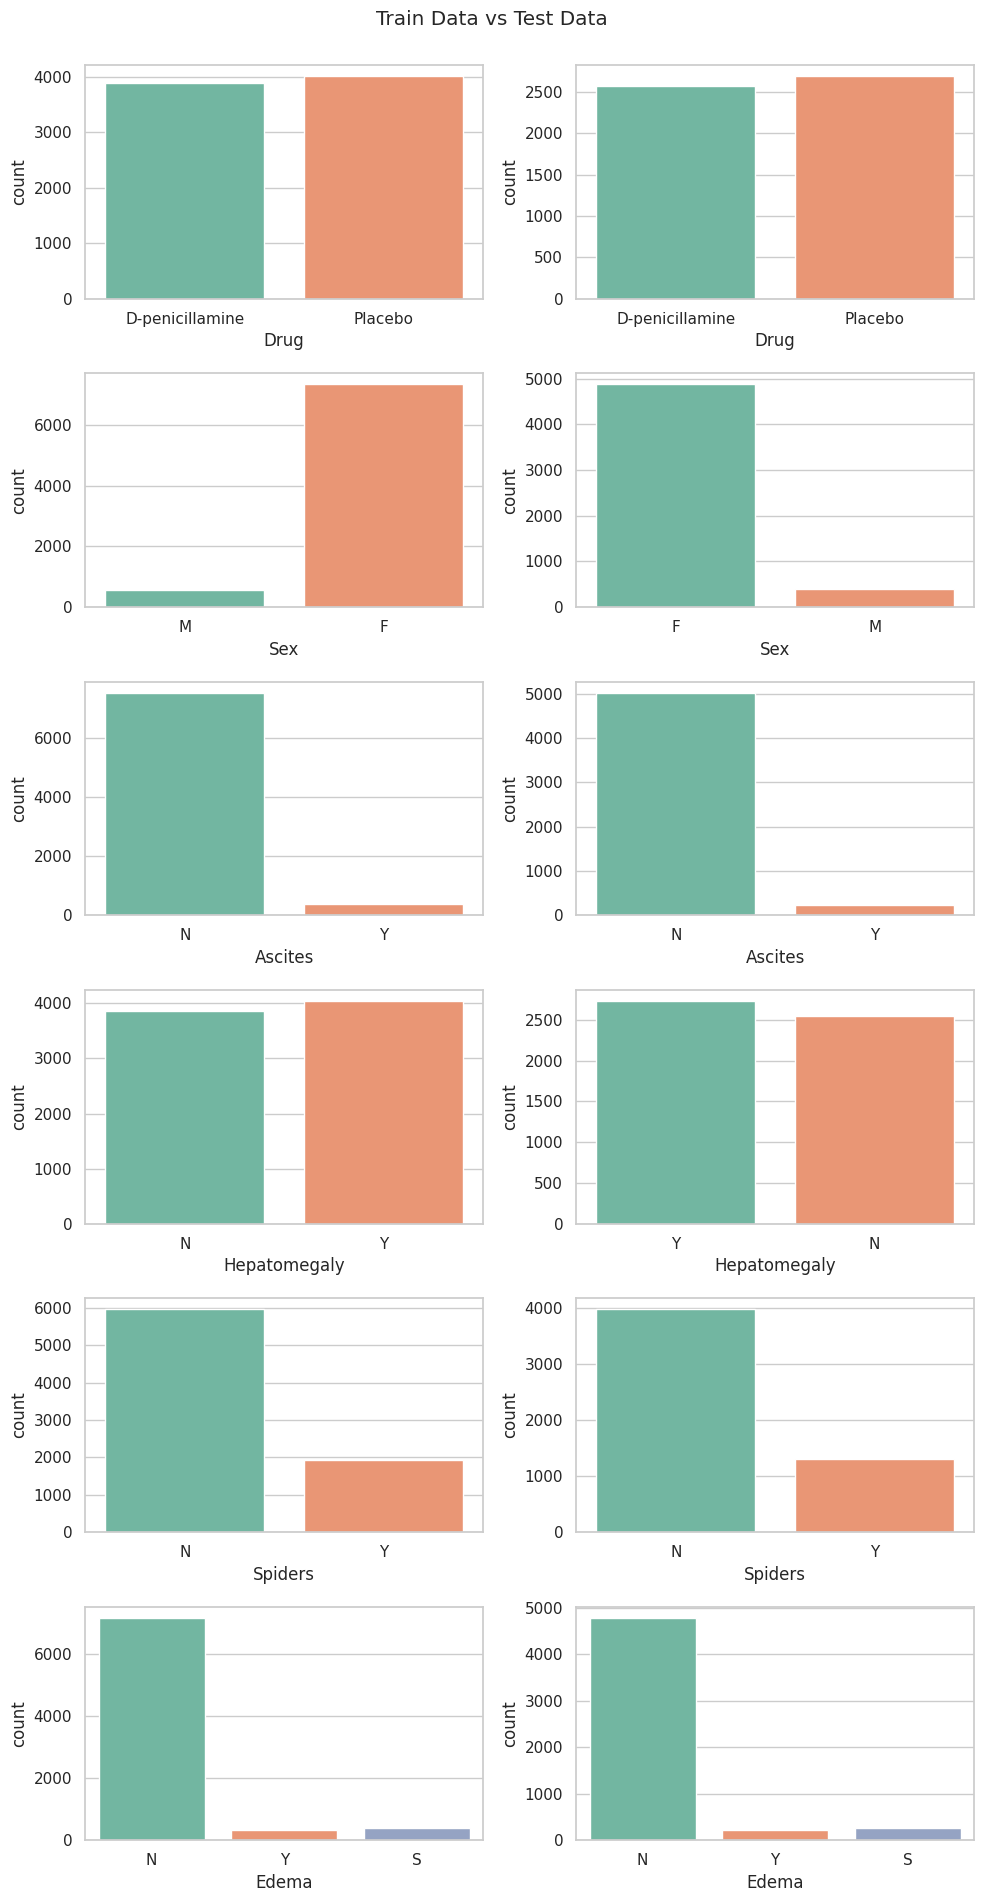

In [11]:
count_comparison(train_data[train_data.columns[:-1]], test_data, title = 'Train Data vs Test Data')

### Test Data vs Original Data Distributions

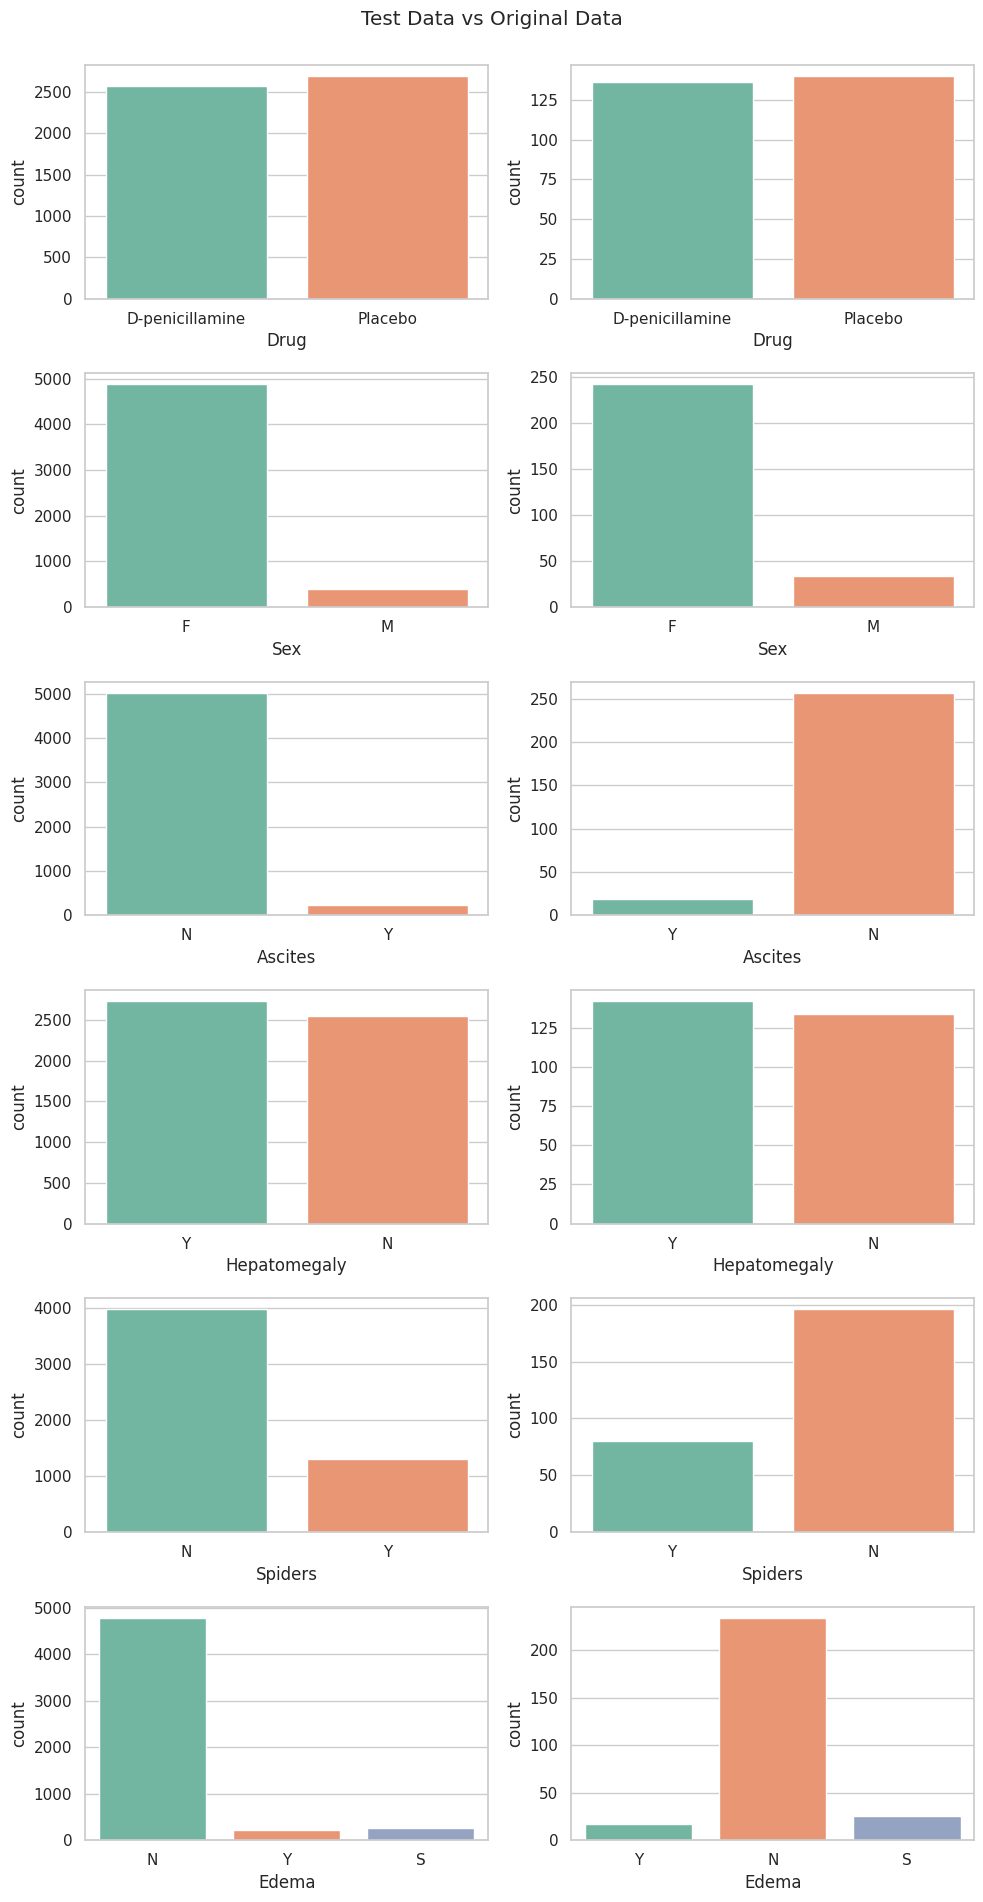

In [12]:
count_comparison(test_data, orig_data[orig_data.columns[:-1]], title = 'Test Data vs Original Data')

## Numerical Distributions

In [13]:
def hist_box_plots(data, bins = 25, kde = True, figsize = (13, 23)):
    data = data.select_dtypes(exclude = 'object')
    nrows, ncols = len(data.columns), 2
    fig, ax = plt.subplots(nrows, ncols, figsize = figsize)
    
    for idx, col in enumerate(data.columns):
        plt.subplot(nrows, ncols, ncols*idx+1)
        sns.histplot(data, x = col, bins = bins, kde = kde)
        
        plt.subplot(nrows, ncols, ncols*idx+2)
        sns.boxplot(data, x = col, orient = 'h')
    
    fig.tight_layout()
    plt.show()

### Train Data

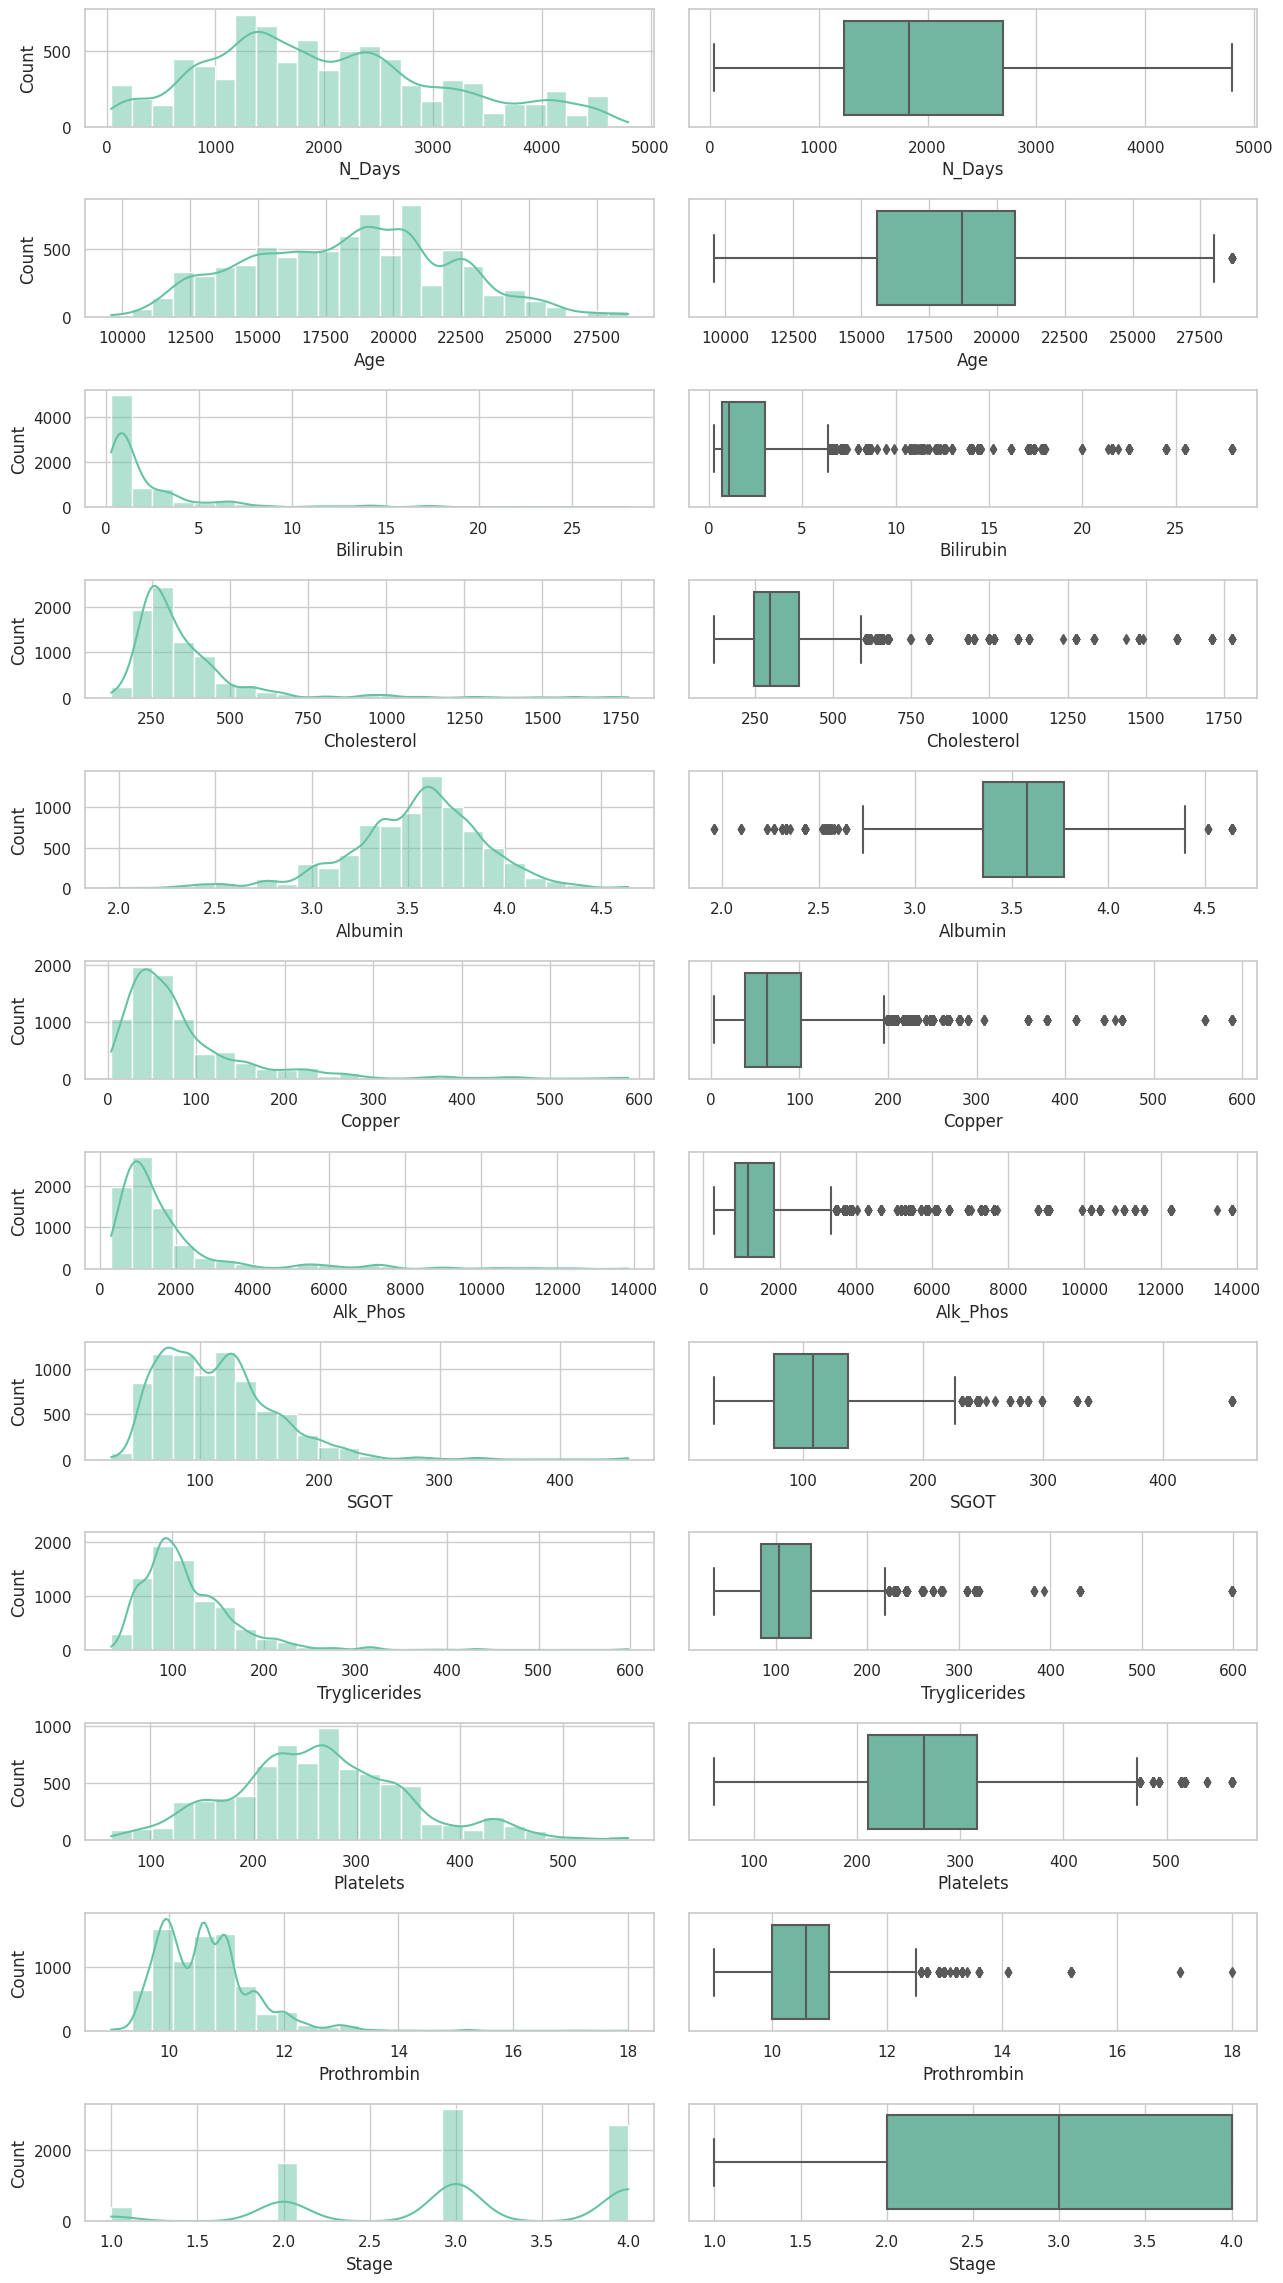

In [14]:
hist_box_plots(train_data)

### Original Data

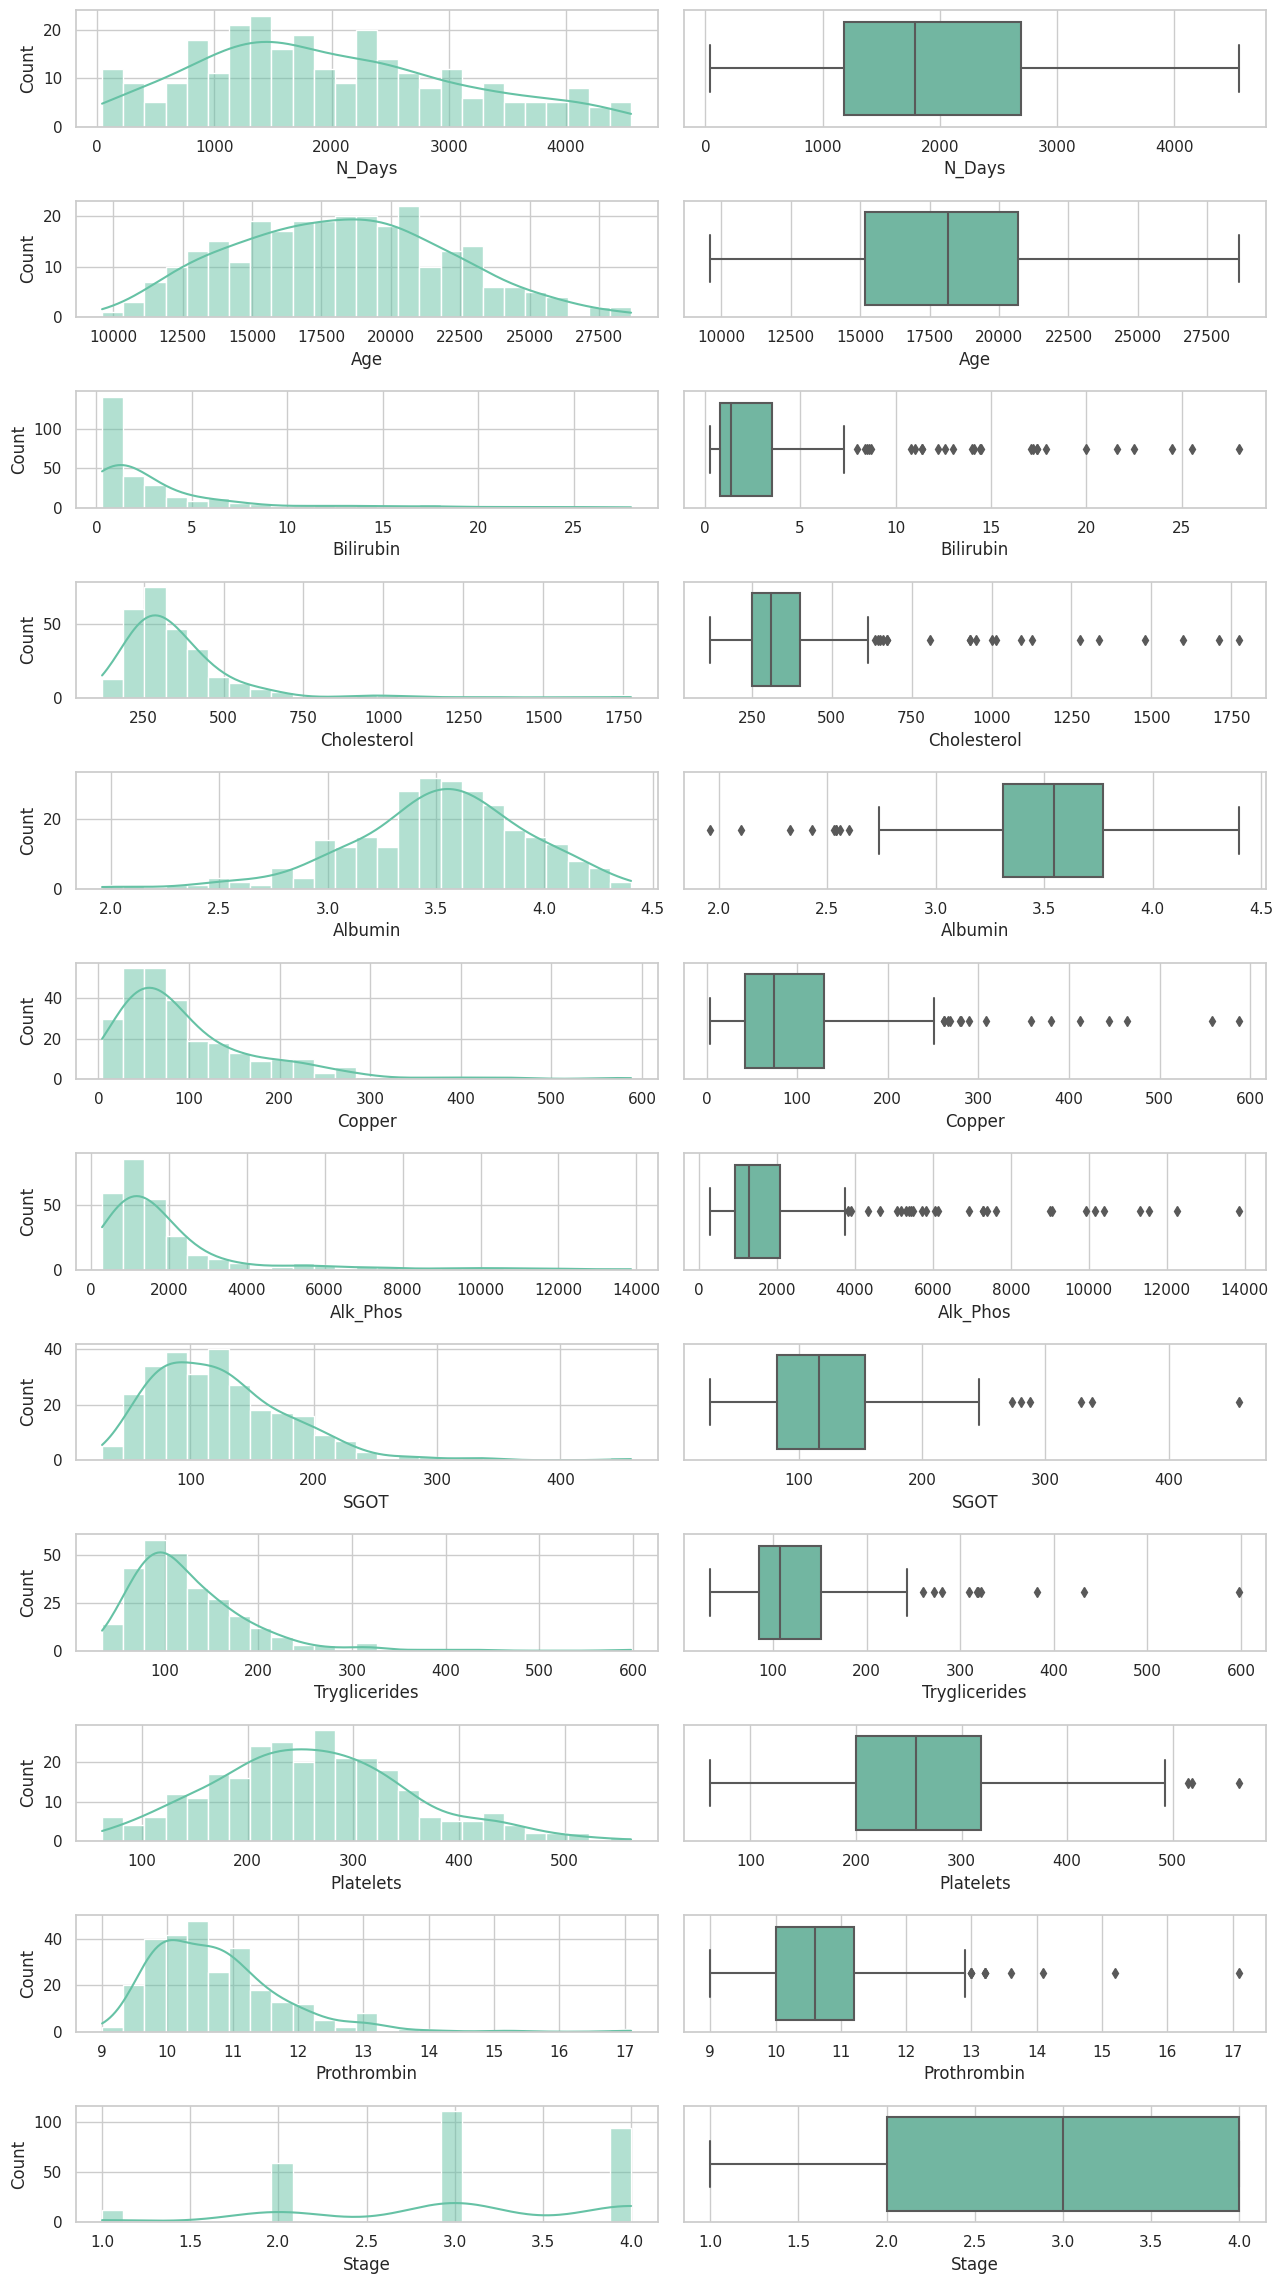

In [15]:
hist_box_plots(orig_data)

### Test Data

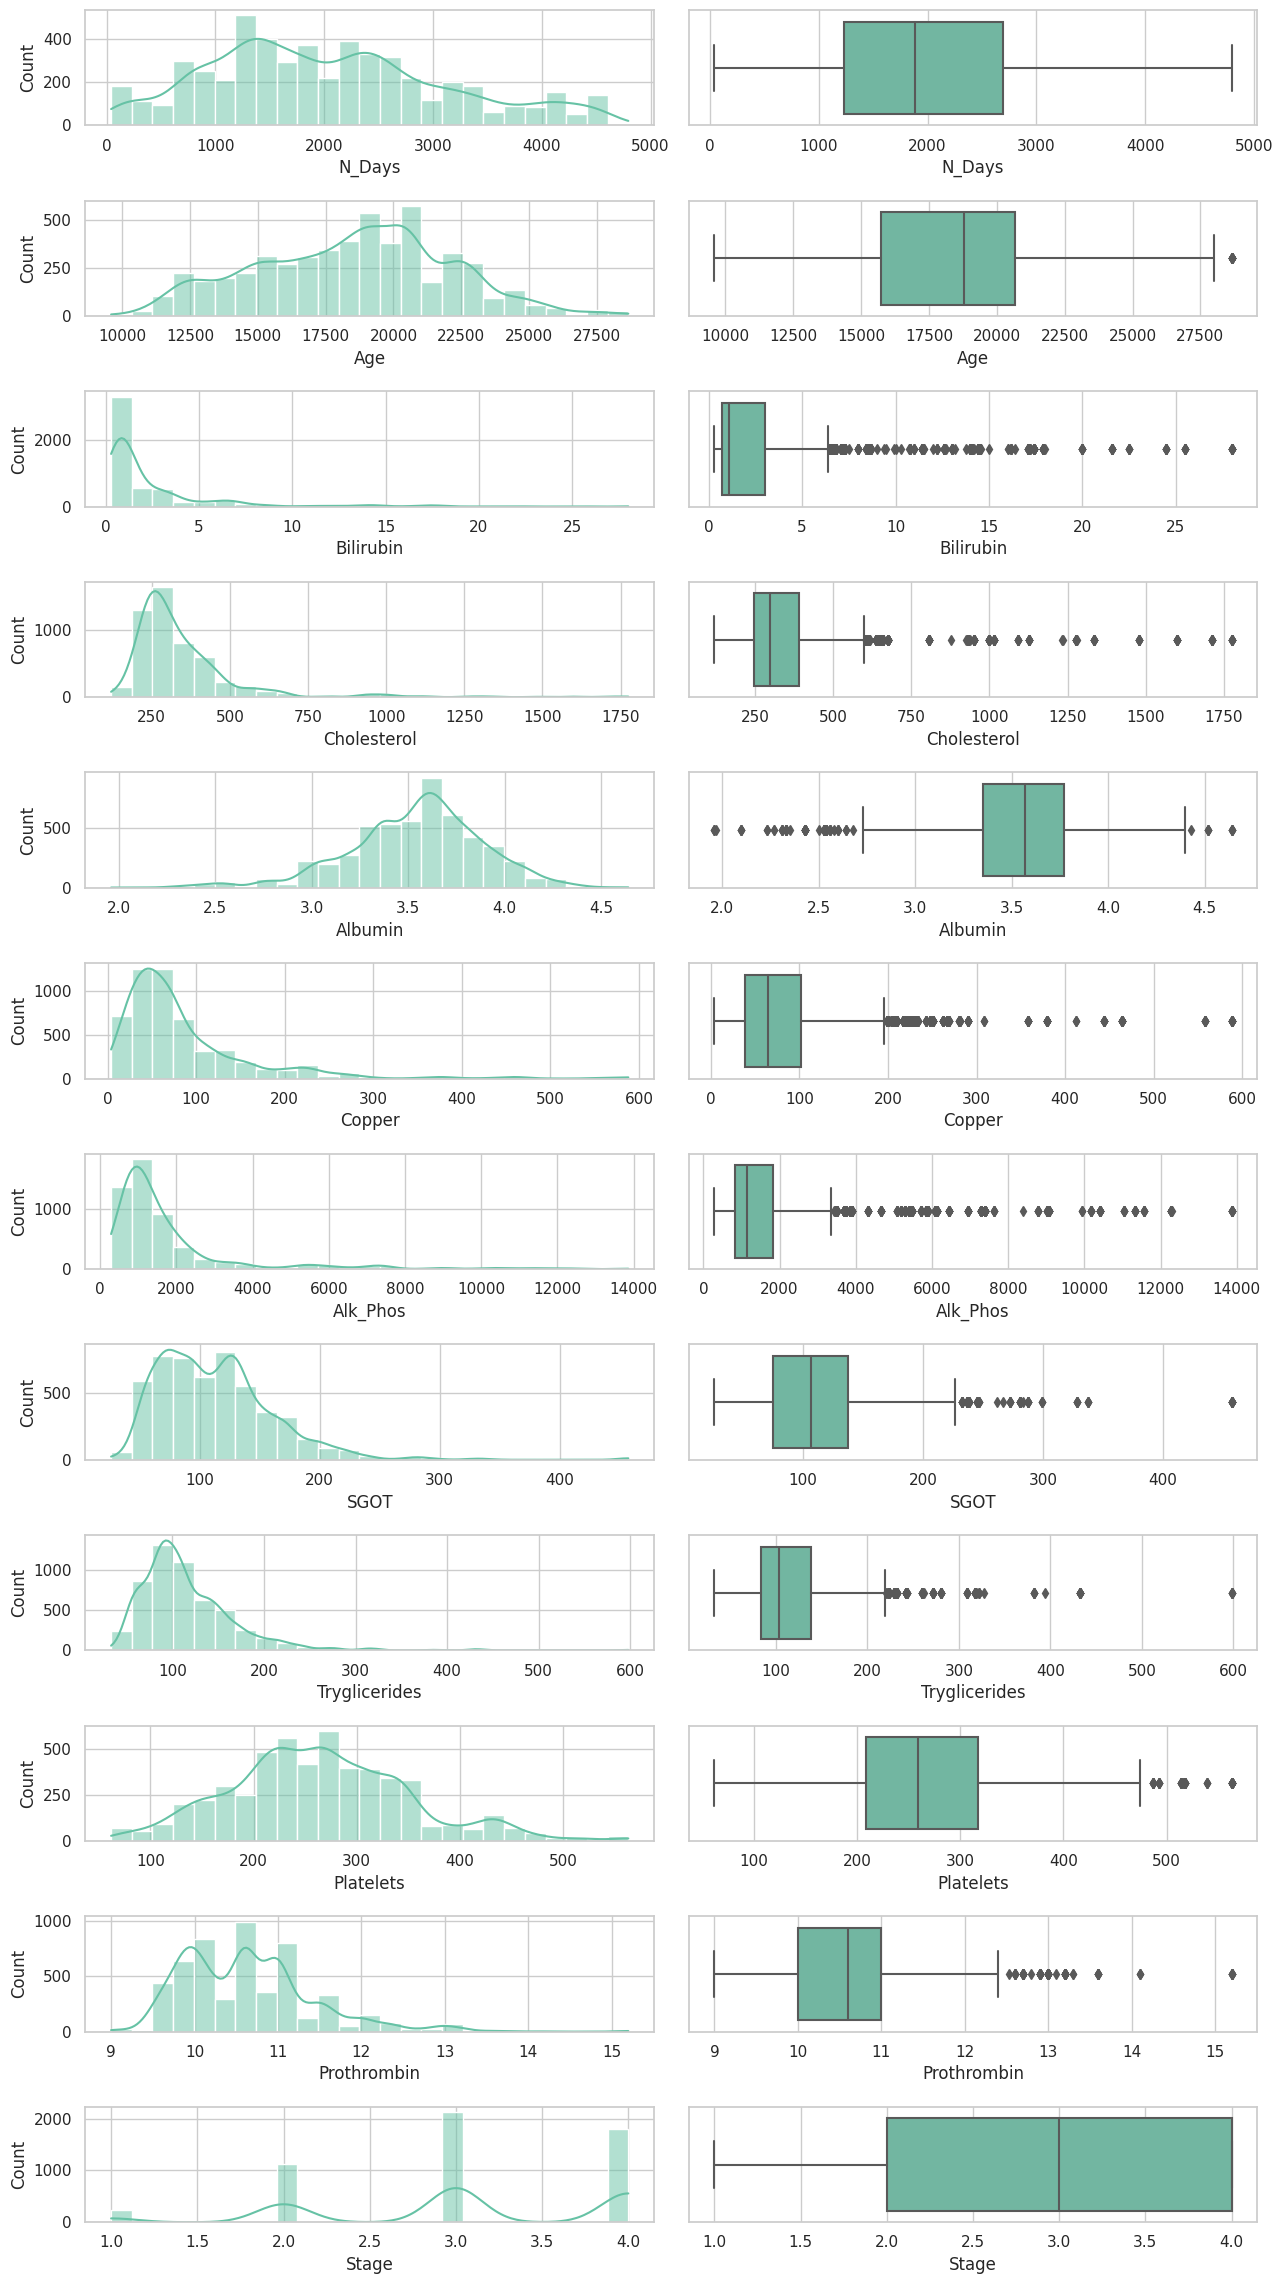

In [16]:
hist_box_plots(test_data)

In [17]:
def hist_dist_comparison(data_1, data_2, title = None, bins = 25, kde = True, figsize = (13, 25)):
    num_1 = data_1.select_dtypes(exclude = 'object')
    num_2 = data_2.select_dtypes(exclude = 'object')
    
    nrows = len(num_1.columns)
    ncols = 2
    
    num_dict = {0: num_1, 1: num_2}
    
    fig, ax = plt.subplots(nrows, ncols, figsize = figsize)
    for i in range(nrows):
        for j in range(ncols):
            sns.histplot(data = num_dict[j], x = num_dict[j].columns[i], bins = bins, kde = kde, ax = ax[i][j])
            
    fig.suptitle(title)
    fig.tight_layout(rect = [0, 0.03, 1, 0.98])
    plt.show()


### Training vs Test Distribution

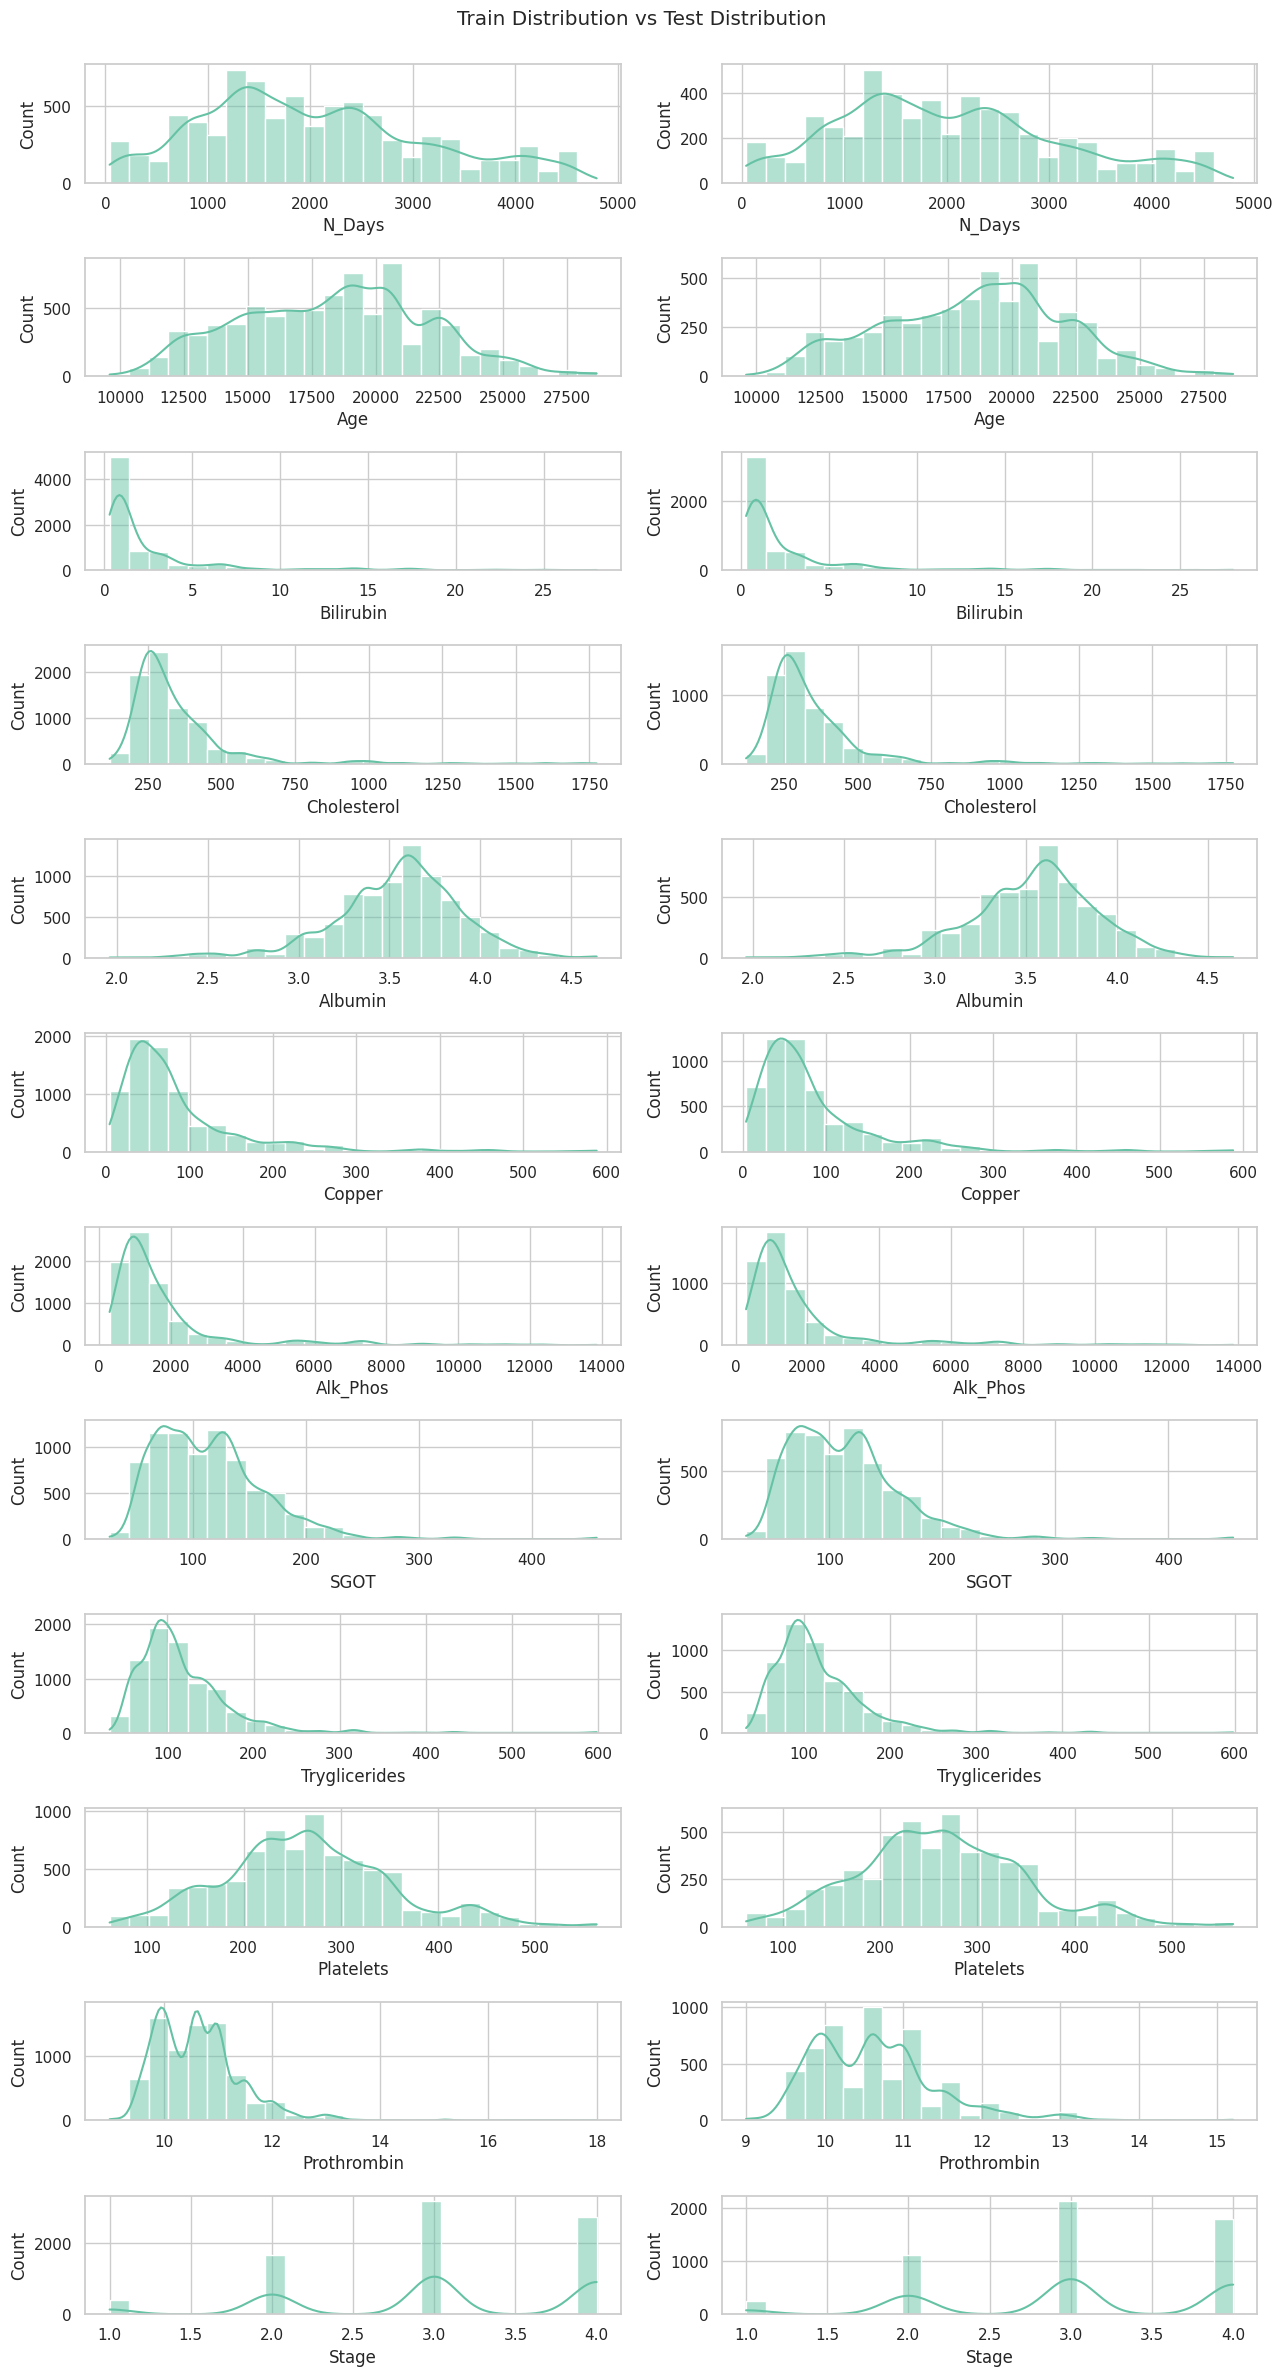

In [18]:
hist_dist_comparison(train_data, test_data, title = 'Train Distribution vs Test Distribution')

### Training vs Original Distribution

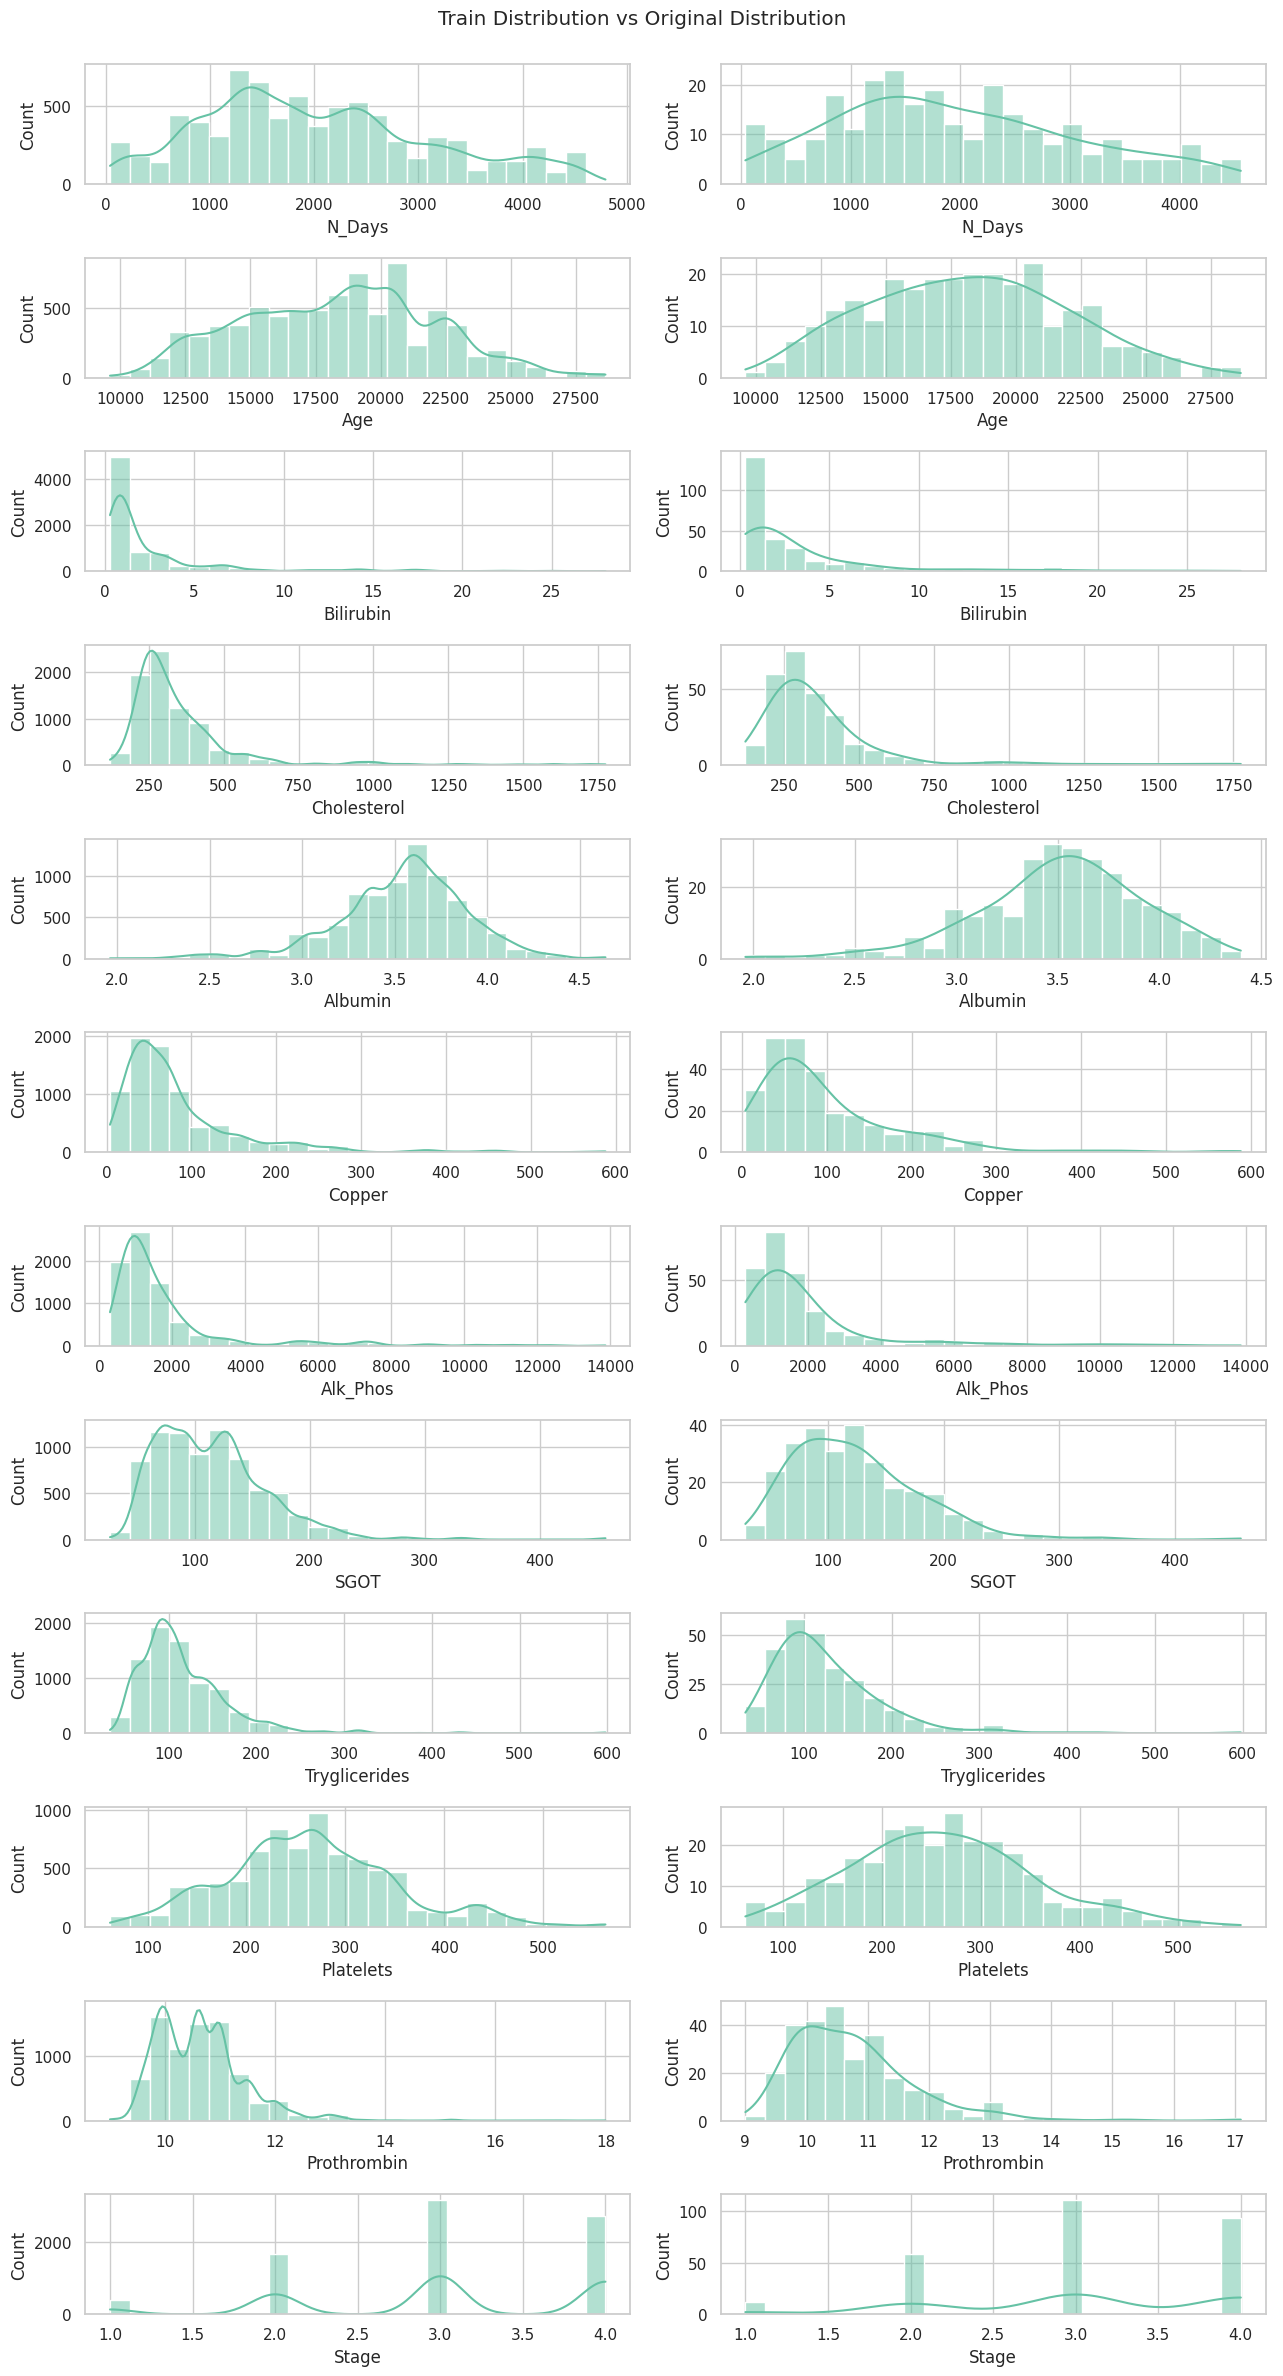

In [19]:
hist_dist_comparison(train_data, orig_data, title = 'Train Distribution vs Original Distribution')

### Correlations

<Axes: >

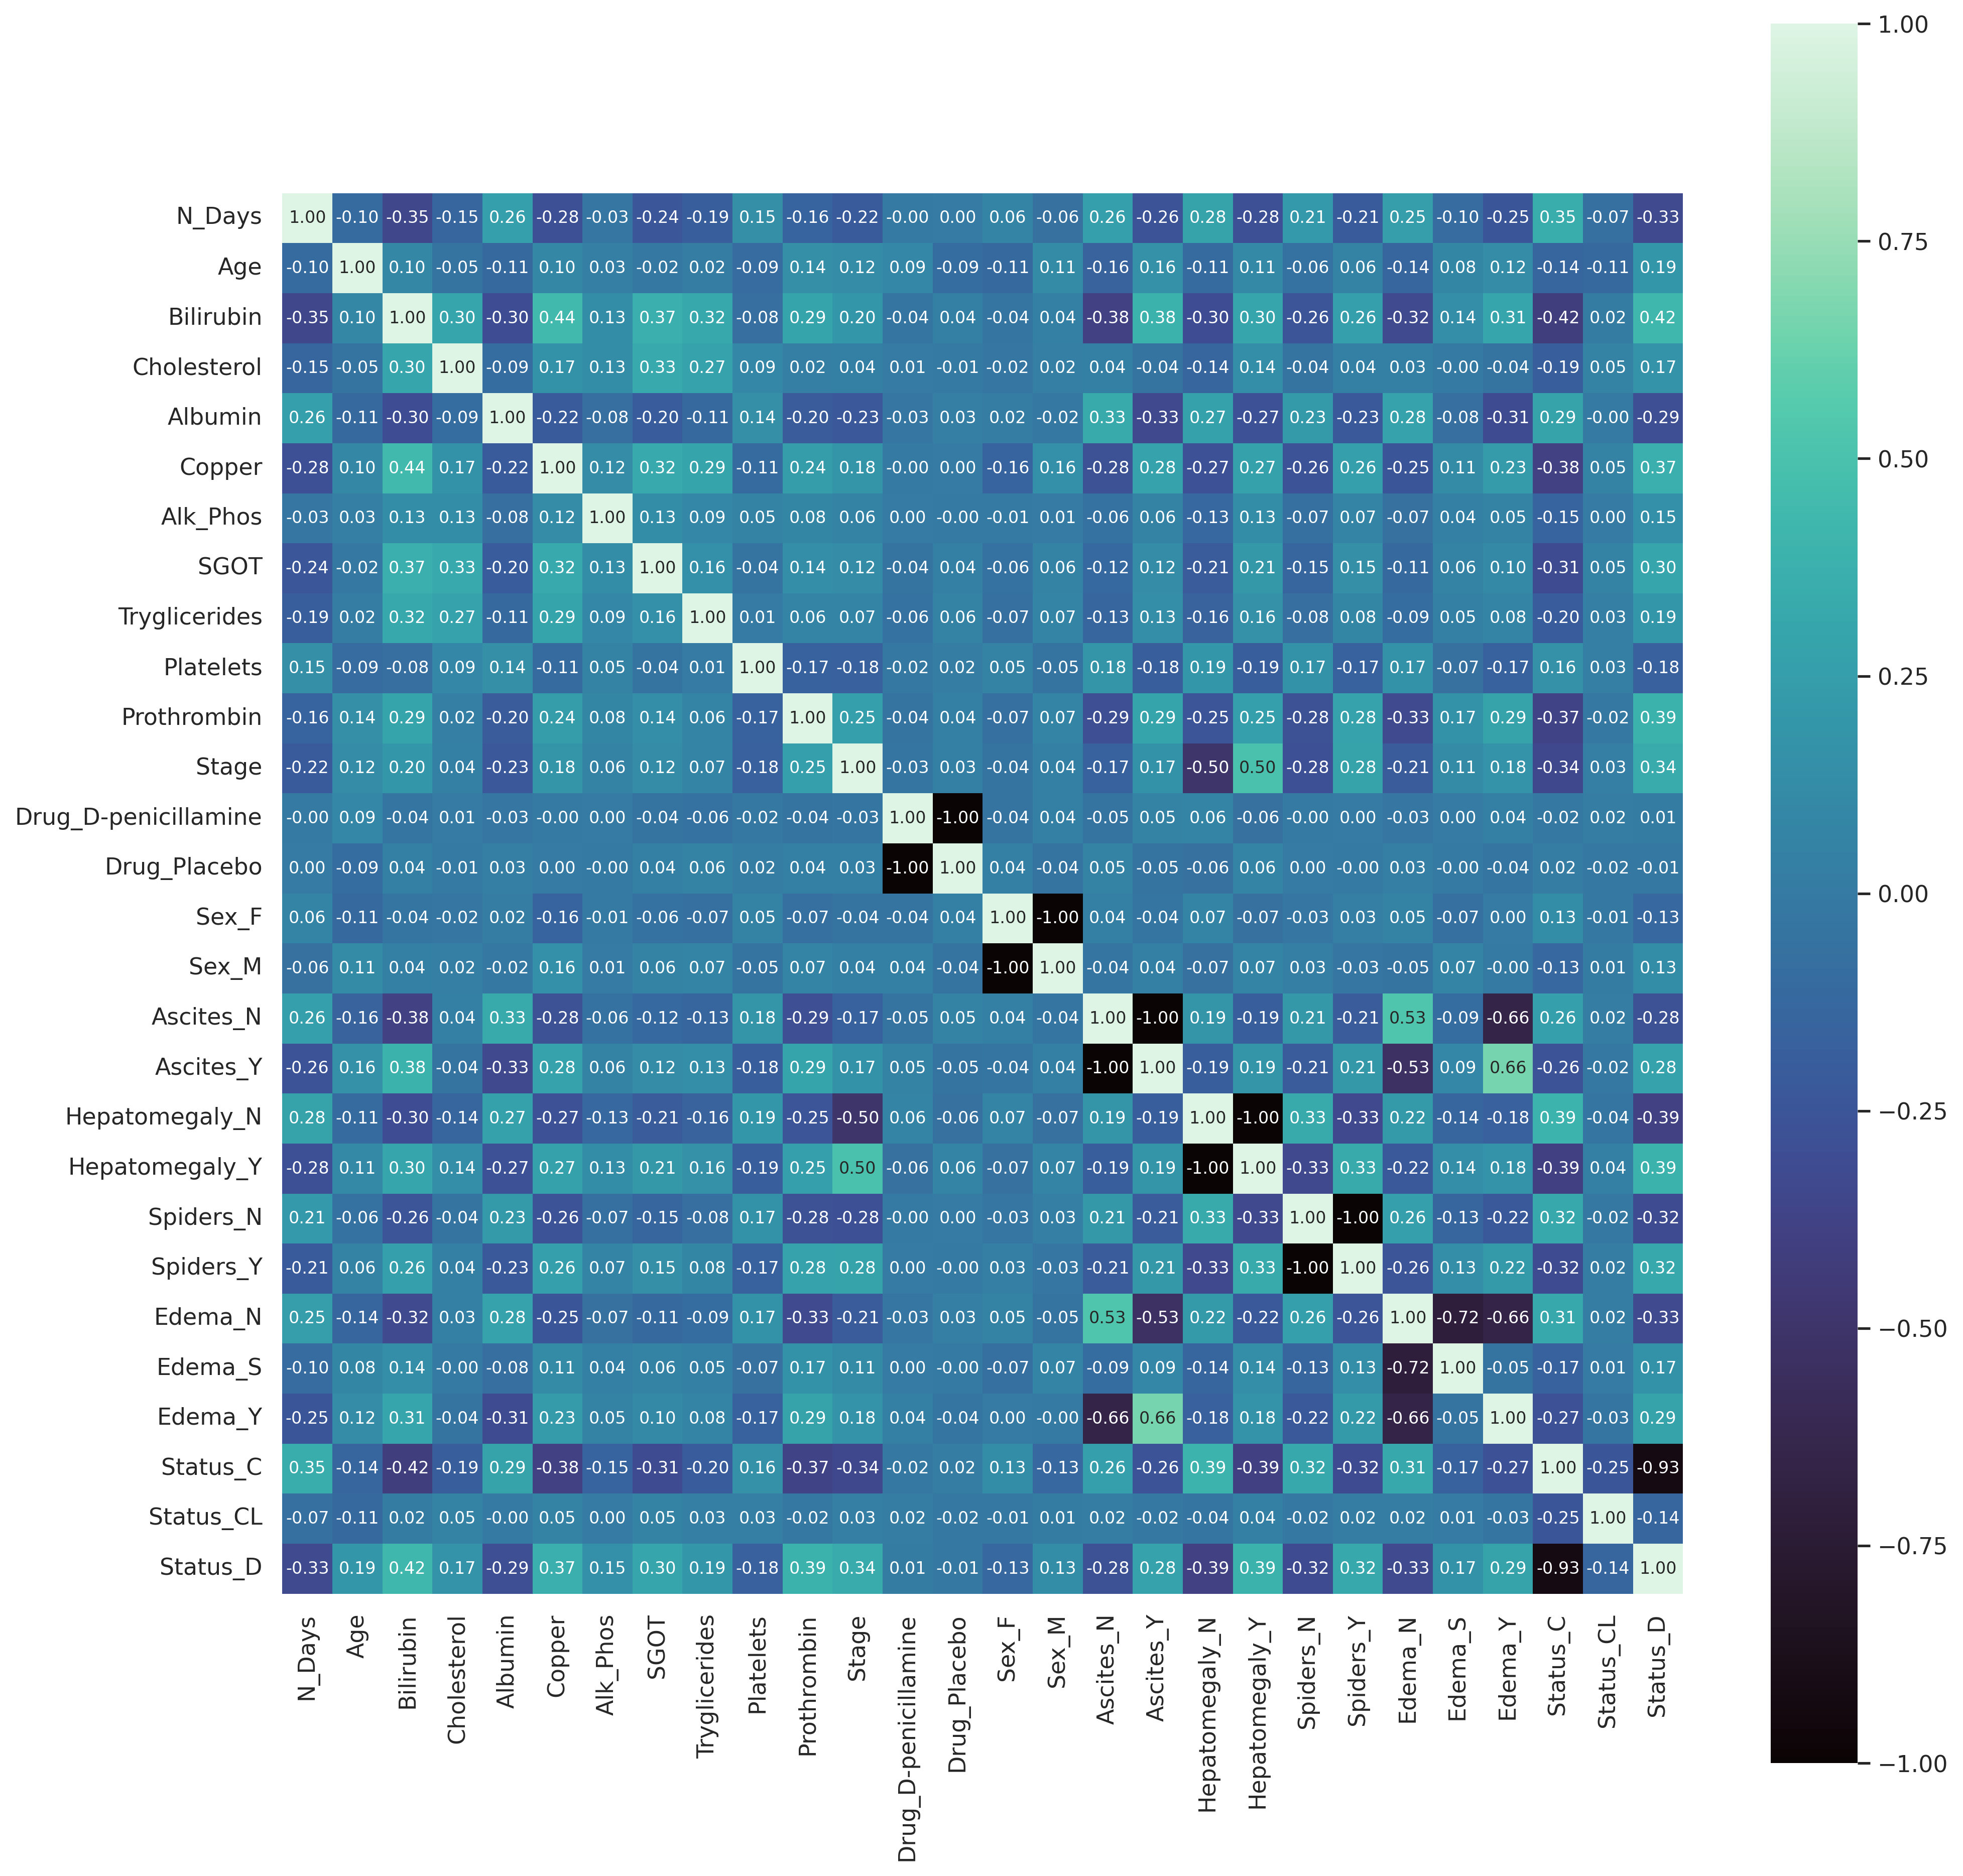

In [20]:
train_w_dummies_corr = pd.get_dummies(train_data).corr()

plt.figure(figsize = (15, 15), dpi = 300)
sns.heatmap(train_w_dummies_corr, square = True, annot = True, fmt = '.2f', cmap = 'mako', annot_kws = {'size':8})

In [21]:
# Merge train and original data
train_orig = pd.concat([train_data, orig_data]).reset_index(drop = True)
train_orig.rename(columns = {'Age':'Age (in days)'}, inplace = True)
train_orig.head()

,N_Days,Drug,Age (in days),Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


## Feature Engineering

In [22]:
def cholesterol_level(value):
    if value < 200:
        return 'Normal'
    elif value >= 200 and value <= 239:
        return 'Elevated'
    else:
        return 'High'

def albumin_level(value):
    if value < 3.5:
        return 'Low'
    elif value >= 3.5 and value <= 5.5:
        return 'Normal'
    else:
        return 'High'

def copper_level(value):
    if value < 62:
        return 'Low'
    elif value >= 62 and value <= 140:
        return 'Normal'
    else:
        return 'High'

def trig_level(value):
    if value < 150:
        return 'Normal'
    elif value >= 150 and value <= 199:
        return 'Borderline High'
    elif value >= 200 and value <= 499:
        return 'High'
    else:
        return 'Very High'

def platelets_range(value):
    if value < 150:
        return 'Low'
    elif value >= 150 and value <= 450:
        return 'Normal'
    else: 
        return 'High'

def prothrombin_speed(value):
    if value >= 10 and value <= 13:
        return 'Normal'
    else:
        return 'Slow'

In [23]:
def feature_engineer(data, target = None):
    
    if target is not None:
        target_col = data[target]
        data = data.drop(target, axis = 1)
        
    data = data.copy()
    
    # Age (in years)
    data['Age (in years)']  = data['Age (in days)'] // 365
    
    # Bilirubin level
    data['Bilirubin_level']  = data['Bilirubin'].apply(lambda x: 'Normal' if x < 1.2 else 'Jaundice')
    
    # Serum cholesterol level
    data['Cholesterol_level'] = data['Cholesterol'].apply(cholesterol_level)
    
    # Albumin level
    data['Albumin_level'] = data['Albumin'].apply(albumin_level)
    
    # Copper level
    data['Copper_level'] = data['Copper'].apply(copper_level)
    
    # Triglycerides level
    data['Triglycerides_level'] = data['Tryglicerides'].apply(trig_level)
    
    # Platelets level
    data['Platelets_range'] = data['Platelets'].apply(platelets_range)
    
    # Prothrombin speed
    data['Prothrombin_speed'] = data['Prothrombin'].apply(prothrombin_speed)
    
    # Date of Diagnosis
    data['Date_of_Diagnosis'] = data['Age (in days)'] - data['N_Days']
    
    # Presence of Diseases
    data['Diseases'] = data['Ascites'] + data['Hepatomegaly'] + data['Spiders'] + data['Edema']
    
    if target is not None:
        data[target] = target_col
    
    for col in data.select_dtypes(exclude = 'object').drop('Stage', axis = 1).columns:
        skewness = data[col].skew()
        if skewness > 0.5:
            data[col] = np.log1p(data[col])
        elif skewness < -0.5:
            data[col] = np.square(data[col])
    
    return data

In [24]:
train_orig = feature_engineer(train_orig, target = 'Status')
train_orig.head()

,N_Days,Drug,Age (in days),Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,...,Bilirubin_level,Cholesterol_level,Albumin_level,Copper_level,Triglycerides_level,Platelets_range,Prothrombin_speed,Date_of_Diagnosis,Diseases,Status
0,999,D-penicillamine,21532,M,N,N,N,N,1.193922,5.758902,...,Jaundice,High,Low,High,Normal,Normal,Slow,20533,NNNN,D
1,2574,Placebo,19237,F,N,N,N,N,0.641854,5.899897,...,Normal,High,Normal,Normal,Normal,Normal,Normal,16663,NNNN,C
2,3428,Placebo,13727,F,N,Y,Y,Y,1.458615,5.703782,...,Jaundice,High,Normal,Normal,Normal,Normal,Normal,10299,NYYY,D
3,2576,Placebo,18460,F,N,N,N,N,0.470004,5.549076,...,Normal,High,Normal,Low,Normal,Normal,Normal,15884,NNNN,C
4,788,Placebo,16658,F,N,Y,N,N,0.741937,5.849325,...,Normal,High,Normal,Normal,Normal,Normal,Normal,15870,NYNN,C


# 4. Modelling

In [25]:
cat_feats = train_orig.select_dtypes(include = 'object').drop('Status', axis = 1).columns.to_list()
num_feats = train_orig.select_dtypes(exclude = 'object').drop('Stage', axis = 1).columns.to_list()

for col in cat_feats:
    print(f'[{col}] Unique Values:\t{train_orig[col].unique()}\n')

[Drug] Unique Values:	['D-penicillamine' 'Placebo']

[Sex] Unique Values:	['M' 'F']

[Ascites] Unique Values:	['N' 'Y']

[Hepatomegaly] Unique Values:	['N' 'Y']

[Spiders] Unique Values:	['N' 'Y']

[Edema] Unique Values:	['N' 'Y' 'S']

[Bilirubin_level] Unique Values:	['Jaundice' 'Normal']

[Cholesterol_level] Unique Values:	['High' 'Elevated' 'Normal']

[Albumin_level] Unique Values:	['Low' 'Normal']

[Copper_level] Unique Values:	['High' 'Normal' 'Low']

[Triglycerides_level] Unique Values:	['Normal' 'High' 'Borderline High' 'Very High']

[Platelets_range] Unique Values:	['Normal' 'Low' 'High']

[Prothrombin_speed] Unique Values:	['Slow' 'Normal']

[Diseases] Unique Values:	['NNNN' 'NYYY' 'NYNN' 'NYYS' 'NYYN' 'YYYY' 'NNNS' 'NYNS' 'NNYN' 'YYNN'
 'YYYS' 'YYNY' 'YNYY' 'YNYN' 'NNYY' 'YYYN' 'NNYS' 'YNNY' 'YYNS' 'NNNY'
 'NYNY' 'YNYS' 'YNNS' 'YNNN']



In [26]:
oh_encoded = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Diseases']
ord_encoded = ['Bilirubin_level', 'Cholesterol_level', 'Albumin_level', 
               'Copper_level', 'Triglycerides_level', 'Platelets_range', 
               'Prothrombin_speed', 'Stage', 'Edema']

In [27]:
random_seed = 42

# Column transformer
col_transformer = make_column_transformer((OneHotEncoder(), oh_encoded),
                                          (OrdinalEncoder(), ord_encoded),
                                          (RobustScaler(), num_feats))

# Separate features and labels
X = col_transformer.fit_transform(train_orig.drop('Status', axis = 1))
y = train_orig['Status'].map({'C':0, 'CL':1, 'D':2}) # target encoding

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = random_seed)

In [28]:
import optuna

def cat_objective(trial):
    params = {
        'logging_level': trial.suggest_categorical('logging_level', ['Silent']),
        "grow_policy" : trial.suggest_categorical('grow_policy', ["Lossguide"]),
        "max_leaves" : trial.suggest_int("max_leaves", 8, 64),
        "random_seed" : trial.suggest_int('random_seed', 1, 30),
        "iterations" : trial.suggest_int("iterations", 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        "depth" : trial.suggest_int("depth", 3, 12),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 3, 15),
        'bagging_temperature' :trial.suggest_float('bagging_temperature', 1, 3),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg',0.01,0.1),
    }
    
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    return log_loss(y_test, y_pred)
    
def xgb_objective(trial):
    params = {
        'objective' : trial.suggest_categorical('objective', ['multi_logloss']),
        'max_depth': trial.suggest_int('max_depth', 7, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log = True),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-3, 1.0, log = True),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0, log = True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0, log = True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log = True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log = True),
        'eval_metric':trial.suggest_categorical('eval_metric', ['mlogloss']),
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    return log_loss(y_test, y_pred)

def lgbm_objective(trial):
    params = {
       'objective': trial.suggest_categorical('objective', ['multi_logloss']),
       'boosting_type' : trial.suggest_categorical('boosting_type', ['gbdt']),
       'max_depth': trial.suggest_int('max_depth', 7, 15),
       'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log = True),
       'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
       'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
       'subsample': trial.suggest_float('subsample', 0.01, 1.0, log = True),
       'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0, log = True),
       'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log = True),
       'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log = True),
   }
    
    model = LGBMClassifier(**params, verbosity = -1)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    return log_loss(y_test, y_pred)

# study = optuna.create_study(direction = 'minimize', 
#                             pruner = optuna.pruners.HyperbandPruner(min_resource = 1, max_resource = 100, reduction_factor = 3))
# optuna.logging.set_verbosity(optuna.logging.INFO)
# study.optimize(xgb_objective, n_trials = 200)
# study.best_params, study.best_value

In [29]:
xgb_params = {'objective': 'multi_logloss',
  'max_depth': 10,
  'learning_rate': 0.04489407209301899,
  'n_estimators': 642,
  'min_child_weight': 1,
  'gamma': 0.819651056890159,
  'subsample': 0.6580886925819325,
  'colsample_bytree': 0.09367053159539084,
  'reg_alpha': 0.006724198448936682,
  'reg_lambda': 0.018990642899812067,
  'eval_metric': 'mlogloss'}

lgbm_params = {'objective': 'multi_logloss',
  'boosting_type': 'gbdt',
  'max_depth': 11,
  'learning_rate': 0.030162815742236303,
  'n_estimators': 561,
  'min_child_weight': 3,
  'subsample': 0.06478040712897938,
  'colsample_bytree': 0.06644897720075163,
  'reg_alpha': 0.7056191591327743,
  'reg_lambda': 0.13133537892159258}

cat_params = {'logging_level': 'Silent',
  'grow_policy': 'Lossguide',
  'max_leaves': 29,
  'random_seed': 23,
  'iterations': 288,
  'learning_rate': 0.06845021206156696,
  'depth': 7,
  'colsample_bylevel': 0.27606202477294245,
  'min_data_in_leaf': 11,
  'bagging_temperature': 1.2476621510700612,
  'leaf_estimation_iterations': 1,
  'l2_leaf_reg': 0.04811980251121926}

In [30]:
models = [('CatBoostClassifier', CatBoostClassifier(**cat_params)),
          ('LGBMClassifier', LGBMClassifier(**lgbm_params, verbosity = -1)),
          ('XGBClassifier', XGBClassifier(**xgb_params))]

metric_fns = [('Log Loss', log_loss),
              ('ROC AUC', roc_auc_score)]

In [31]:
def calculate_metrics(y_test, y_pred, metric_fns):
    # Dictionary to store the score for each metric
    results = {}
    
    # Loop through each metric 
    for metric_fn in metric_fns:
        # Calculate score using metric
        if metric_fn[0] == 'ROC AUC':
            score = metric_fn[1](y_test, y_pred, multi_class = 'ovr')
        else:
            score = metric_fn[1](y_test, y_pred)
        
        # Store score as value and metric as key
        results[metric_fn[0]] = score
        
        # Display metric score
        print(f'{metric_fn[0]} : {score}')
    return results

def cross_validate(models, X, y, n_splits = 10, metric_fns = None, shuffle = True, random_seed = None):
    # Dictionaries to store oof predictions and oof metric scores
    oof_preds, oof_metrics = {}, {}
    x_data, y_data = [], []
    
    skf = StratifiedKFold(n_splits = n_splits, shuffle = shuffle, random_state = random_seed)
    
    for idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f'Fold #{idx+1}:')
        print(f'-'*40+'\n')
        
        # Split into train and test splits
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Store test splits
        x_data.extend(x_test)
        y_data.extend(y_test)
        
        # Iterate through models and cross-validate each one
        for model in models:
            print(f'Cross-validating: [{model[0]}]\n')
            
            if model[0] not in oof_preds:
                oof_preds[model[0]] = []
                oof_metrics[model[0]] = {}
                
            model[1].fit(x_train, y_train)
            y_pred = model[1].predict_proba(x_test)
            oof_preds[model[0]].append(y_pred) # store prediction in dictionary
            
            # Calculate metrics 
            for metric_name, result in calculate_metrics(y_test, y_pred, metric_fns).items():
                if metric_name not in oof_metrics[model[0]]:
                    oof_metrics[model[0]][metric_name] = []
                oof_metrics[model[0]][metric_name].append(result) # store result in metrics dictionary
            print('\n')
    
    return oof_preds, oof_metrics, (np.vstack(x_data), np.array(y_data))

In [32]:
oof_preds, oof_metrics, data = cross_validate(models, X, y, n_splits = 5, metric_fns = metric_fns, random_seed = random_seed)

Fold #1:
----------------------------------------

Cross-validating: [CatBoostClassifier]

Log Loss : 0.45139962488071206
ROC AUC : 0.8834439683867621


Cross-validating: [LGBMClassifier]

Log Loss : 0.42423263356287216
ROC AUC : 0.8990053959260922


Cross-validating: [XGBClassifier]

Log Loss : 0.42059059352712497
ROC AUC : 0.9039530981554244


Fold #2:
----------------------------------------

Cross-validating: [CatBoostClassifier]

Log Loss : 0.46395761035246535
ROC AUC : 0.8738364634973746


Cross-validating: [LGBMClassifier]

Log Loss : 0.44116925821504377
ROC AUC : 0.8905121039290363


Cross-validating: [XGBClassifier]

Log Loss : 0.44394621110604887
ROC AUC : 0.8867688227772538


Fold #3:
----------------------------------------

Cross-validating: [CatBoostClassifier]

Log Loss : 0.4446144648205792
ROC AUC : 0.8873376865903041


Cross-validating: [LGBMClassifier]

Log Loss : 0.41257107433869955
ROC AUC : 0.9052081097972557


Cross-validating: [XGBClassifier]

Log Loss : 0.415410

In [33]:
# Get out-of-fold metrics 
def get_oof_metrics(metric_dict):
    dict, df = {'models' : []}, pd.DataFrame()
    for model in list(metric_dict.keys()):
        dict['models'].append(model)
        for metric in list(metric_dict[model].keys()):
            if metric not in dict:
                dict[metric] = []
            dict[metric].append(np.mean(metric_dict[model][metric]))
    
    df.index = dict['models']
    for metric in list(dict.keys())[1:]:
        df[metric] = dict[metric]
    
    return df

In [34]:
oof_metrics_df = get_oof_metrics(oof_metrics)
oof_metrics_df.sort_values(by = 'Log Loss', ascending = True)

,Log Loss,ROC AUC
XGBClassifier,0.416758,0.903758
LGBMClassifier,0.416880,0.904342
CatBoostClassifier,0.442530,0.887148


In [35]:
oof_metrics_df.sort_values(by = 'ROC AUC', ascending = False)

,Log Loss,ROC AUC
LGBMClassifier,0.416880,0.904342
XGBClassifier,0.416758,0.903758
CatBoostClassifier,0.442530,0.887148


In [36]:
class WeightedEnsemble:
    def __init__(self, models, weights = None, random_state = None):
        np.random.seed(random_state)
        self.models = models
        self.weights = np.random.sample(size = (len(models), 1)) if weights is None else np.array(weights).reshape(-1, 1)
        self.target_unique = None
        
    def fit(self, X, y, sample_weight = None):
        fitted = []
        self.target_unique = len(np.unique(y))
        for model in self.models:
            if sample_weight is None:
                model.fit(X, y)
            else: 
                model.fit(X, y, sample_weight = sample_weight)
            fitted.append(model)
        self.models = fitted
    
    def predict(self, X):
        preds = np.zeros(shape = (len(self.models), len(X)))
        for idx, model in enumerate(self.models):
            preds[idx] = model.predict(X) * self.weights[idx]
        return np.sum(preds, axis = 0) / np.sum(self.weights)
    
    def predict_proba(self, X):
        weighted_probs = np.zeros(shape=(len(self.models), len(X), self.target_unique))
        for idx, model in enumerate(self.models):
            probs = model.predict_proba(X)
            weighted_probs[idx] = probs * self.weights[idx]
        final_probs = np.sum(weighted_probs, axis=0) / np.sum(self.weights)
        return final_probs

In [37]:
top_models = [('XGGClassifier', XGBClassifier(**xgb_params)), 
              ('LGBMClassifier', LGBMClassifier(**lgbm_params, verbosity = -1)),
              ('CatBoostClassifier', CatBoostClassifier(**cat_params))]

In [38]:
import optuna

def we_objective(trial):
    weights = [trial.suggest_float(f'w_{i}', 0.1, 0.9) for i in range(len(top_models))]
    model = WeightedEnsemble([model[1] for model in top_models], weights)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    return log_loss(y_test, y_pred)

study = optuna.create_study(direction = 'minimize')
optuna.logging.set_verbosity(optuna.logging.INFO)
study.optimize(we_objective, n_trials = 100)
study.best_params, study.best_value

[I 2024-03-14 22:39:20,056] A new study created in memory with name: no-name-0a5623ca-b20a-4223-a571-e2c3a99d30a5
[I 2024-03-14 22:39:37,421] Trial 0 finished with value: 0.4157754094875266 and parameters: {'w_0': 0.8468735600506331, 'w_1': 0.4957913250674747, 'w_2': 0.5615526545232604}. Best is trial 0 with value: 0.4157754094875266.
[I 2024-03-14 22:39:54,402] Trial 1 finished with value: 0.41453768923976114 and parameters: {'w_0': 0.5034436135765764, 'w_1': 0.7435174761806335, 'w_2': 0.11006502544347417}. Best is trial 1 with value: 0.41453768923976114.
[I 2024-03-14 22:40:12,453] Trial 2 finished with value: 0.4149876056740654 and parameters: {'w_0': 0.5124726105846847, 'w_1': 0.26176726467026457, 'w_2': 0.1957173398784705}. Best is trial 1 with value: 0.41453768923976114.
[I 2024-03-14 22:40:29,857] Trial 3 finished with value: 0.41795769386695786 and parameters: {'w_0': 0.27798112550573606, 'w_1': 0.6249932747702889, 'w_2': 0.8140262237234448}. Best is trial 1 with value: 0.41453

({'w_0': 0.8349044765638256,
  'w_1': 0.7047890553756968,
  'w_2': 0.1499790359392313},
 0.41440321768955696)

In [39]:
we_params = {'w_0': 0.899974857644609,
  'w_1': 0.10331074212653452,
  'w_2': 0.45767441044005264} 

we = WeightedEnsemble([model[1] for model in top_models], weights = [weight for weight in we_params.values()])

In [40]:
models = [('CatBoostClassifier', CatBoostClassifier(**cat_params)), 
          ('LGBMClassifier', LGBMClassifier(**lgbm_params, verbosity = -1)), 
          ('XGBClassifier', XGBClassifier(**xgb_params)),
          ('WeightedEnsemble', we)]

In [41]:
top_oof_preds, top_oof_scores, top_data = cross_validate(models, X, y, n_splits = 10, metric_fns = metric_fns, random_seed = random_seed)

Fold #1:
----------------------------------------

Cross-validating: [CatBoostClassifier]

Log Loss : 0.4629733490837283
ROC AUC : 0.8850930510627636


Cross-validating: [LGBMClassifier]

Log Loss : 0.42676737038859924
ROC AUC : 0.908506460530083


Cross-validating: [XGBClassifier]

Log Loss : 0.43139422519267023
ROC AUC : 0.9059150560987482


Cross-validating: [WeightedEnsemble]

Log Loss : 0.4351188769218162
ROC AUC : 0.9033476561691179


Fold #2:
----------------------------------------

Cross-validating: [CatBoostClassifier]

Log Loss : 0.42291005092662576
ROC AUC : 0.9023440303731635


Cross-validating: [LGBMClassifier]

Log Loss : 0.41351840453304317
ROC AUC : 0.8967308769165697


Cross-validating: [XGBClassifier]

Log Loss : 0.4081244965773614
ROC AUC : 0.9038535612049515


Cross-validating: [WeightedEnsemble]

Log Loss : 0.40820290822855204
ROC AUC : 0.9062630561459089


Fold #3:
----------------------------------------

Cross-validating: [CatBoostClassifier]

Log Loss : 0.4685

In [42]:
top_oof_metrics_df = get_oof_metrics(top_oof_scores)
top_oof_metrics_df.sort_values(by = 'Log Loss', ascending = True)

,Log Loss,ROC AUC
XGBClassifier,0.415686,0.904691
LGBMClassifier,0.415788,0.905302
WeightedEnsemble,0.418307,0.903097
CatBoostClassifier,0.441645,0.886869


In [43]:
top_oof_metrics_df.sort_values(by= 'ROC AUC', ascending = False)

,Log Loss,ROC AUC
LGBMClassifier,0.415788,0.905302
XGBClassifier,0.415686,0.904691
WeightedEnsemble,0.418307,0.903097
CatBoostClassifier,0.441645,0.886869


# 5. Predicting on Test Data

In [44]:
test_data.rename(columns = {'Age':'Age (in days)'}, inplace = True)
test_trans = feature_engineer(test_data)
test_trans.head()

,N_Days,Drug,Age (in days),Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,...,Age (in years),Bilirubin_level,Cholesterol_level,Albumin_level,Copper_level,Triglycerides_level,Platelets_range,Prothrombin_speed,Date_of_Diagnosis,Diseases
0,3839,D-penicillamine,19724,F,N,Y,N,N,0.788457,6.304449,...,54,Jaundice,High,Low,Normal,Normal,Normal,Normal,15885,NYNN
1,2468,D-penicillamine,14975,F,N,N,N,N,0.741937,6.493754,...,41,Normal,High,Normal,Normal,Borderline High,Normal,Normal,12507,NNNN
2,51,Placebo,13149,F,N,Y,N,Y,1.098612,5.023881,...,36,Jaundice,Normal,Low,Low,Normal,Normal,Normal,13098,NYNY
3,2330,D-penicillamine,20510,F,N,N,N,N,0.470004,5.683580,...,56,Normal,High,Normal,Low,Normal,Normal,Normal,18180,NNNN
4,1615,D-penicillamine,21904,F,N,Y,N,N,0.875469,5.627621,...,60,Jaundice,High,Low,Normal,Normal,Normal,Slow,20289,NYNN


In [45]:
test_trans = col_transformer.transform(test_trans)

In [46]:
def create_meta_dataset(data, pred_dict):
    ph_data = data
    for model in list(pred_dict.keys()):
        model_preds = np.concatenate(pred_dict[model])
        ph_data = np.concatenate([ph_data, model_preds], axis = 1)
    return ph_data

metadata = create_meta_dataset(top_data[0], top_oof_preds)
metadata.shape

(8181, 68)

In [47]:
def make_predictions(models, X, y, target):
    pred_dict, ph_data = {}, target
    for model in models:
        print(f'Now Predicting on Target: [{model[0]}]')
        print('-'*50+'\n')
        model[1].fit(X, y)
        y_pred = model[1].predict_proba(target)
        if model[0] not in pred_dict:
            pred_dict[model[0]] = y_pred
        ph_data = np.concatenate([ph_data, y_pred], axis = 1)
    print(f'>>> Done')
    return pred_dict, ph_data

model_test_preds, model_test_data = make_predictions(models, top_data[0], top_data[1], test_trans)

Now Predicting on Target: [CatBoostClassifier]
--------------------------------------------------

Now Predicting on Target: [LGBMClassifier]
--------------------------------------------------

Now Predicting on Target: [XGBClassifier]
--------------------------------------------------

Now Predicting on Target: [WeightedEnsemble]
--------------------------------------------------

>>> Done


In [48]:
final_test_preds, final_test_data = make_predictions(models, metadata, top_data[1], model_test_data)

Now Predicting on Target: [CatBoostClassifier]
--------------------------------------------------

Now Predicting on Target: [LGBMClassifier]
--------------------------------------------------

Now Predicting on Target: [XGBClassifier]
--------------------------------------------------

Now Predicting on Target: [WeightedEnsemble]
--------------------------------------------------

>>> Done


In [49]:
final_preds = (final_test_preds['XGBClassifier']*0.7 + 
               final_test_preds['WeightedEnsemble']*0.3) / (0.7 + 0.3)
final_preds

array([[0.31626149, 0.00901601, 0.67472249],
       [0.45390286, 0.18606973, 0.3600274 ],
       [0.02058867, 0.01209494, 0.96731638],
       ...,
       [0.96198647, 0.00483388, 0.03317965],
       [0.96038931, 0.01720928, 0.02240139],
       [0.55012283, 0.01120017, 0.43867697]])

# 6. Create Submission

In [50]:
submission = sample_sub.copy()
submission['Status_C'] = final_test_preds['WeightedEnsemble'][:, 0]
submission['Status_CL'] = final_test_preds['WeightedEnsemble'][:, 1]
submission['Status_D'] = final_test_preds['WeightedEnsemble'][:, 2]

id_col = submission['id']
submission = submission.drop('id', axis = 1)
submission.index = id_col

submission.head()

,Status_C,Status_CL,Status_D
id,,,
7905,0.318965,0.009019,0.672016
7906,0.399690,0.185551,0.414759
7907,0.019477,0.011316,0.969207
7908,0.984519,0.002086,0.013395
7909,0.921243,0.024193,0.054564


In [51]:
submission.to_csv('submission.csv')